# Getting started

Once you've chosen your scenario from the README, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

## Scenario and Problem Statement

The powers that be once again spent tax payers money on lavish and unnecessary goods and now must figure out a new way to generate income to prevent the closure of state owned public facilities. They have decided to tax all activities that the regular working folk enjoys to generate that income they carelessly spent. An estimate of projected sales is needed from many industries including, liquor sales in order to tax accordingly.   

In [1]:
import pandas as pd
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model
## Load the data into a DataFrame
# pd.read_csv()

## Transform the dates if needed, e.g.
# df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y")

In [2]:
df = pd.read_csv("../../assets/Iowa_Liquor_sales_sample_10pct.csv", parse_dates = ["Date"])

In [3]:
del df["Category Name"]
del df["Item Description"]
del df["County"]



In [4]:
df["State Bottle Cost"]   = df["State Bottle Cost"].apply( lambda cost: float(cost.replace("$","")))
df["State Bottle Retail"] = df["State Bottle Retail"].apply( lambda cost: float(cost.replace("$","")))
df["Sale (Dollars)"]      = df["Sale (Dollars)"].apply( lambda cost: float(cost.replace("$","")))
df["Month"] = df["Date"].apply(lambda date: date.month)
df["quarter"] = df.Date.apply(lambda date: date.quarter)
df["Year"] = df.Date.apply(lambda date: date.year)
df.columns = df.columns.str.replace(" ", "_")


In [5]:
df = df.dropna()

In [6]:
df.shape

(269810, 18)

In [7]:
df["County_Number"] = df["County_Number"].astype(int)
df["Category"] = df["Category"].astype(int)
df.head()

,Date,Store_Number,City,Zip_Code,County_Number,Category,Vendor_Number,Item_Number,Bottle_Volume_(ml),State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_(Dollars),Volume_Sold_(Liters),Volume_Sold_(Gallons),Month,quarter,Year
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38,11,4,2015
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40,3,1,2016
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34,2,1,2016
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77,2,1,2016
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55,8,3,2015


In [8]:
df['Sale_(Dollars)'].sum()

34796119.35000121

In [9]:
dates = df.groupby(by=["Store_Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()

lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store_Number"]
df = df[df["Store_Number"].isin(good_stores)]

In [10]:
df["Margin"] = (df["State_Bottle_Retail"] - df["State_Bottle_Cost"]) * df["Bottles_Sold"]
df["Price_per_Liter"] = df["Sale_(Dollars)"] / df["Volume_Sold_(Liters)"]
df.head()

,Date,Store_Number,City,Zip_Code,County_Number,Category,Vendor_Number,Item_Number,Bottle_Volume_(ml),State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_(Dollars),Volume_Sold_(Liters),Volume_Sold_(Gallons),Month,quarter,Year,Margin,Price_per_Liter
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38,11,4,2015,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40,3,1,2016,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34,2,1,2016,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77,2,1,2016,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55,8,3,2015,43.20,6.171429


In [11]:
# Sales per store, 2015

#Filter by our start and end dates
df.sort_values(by=["Store_Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)

sales = df[mask]





In [12]:
# Group by store name
sales = sales.groupby(by=["Store_Number"], as_index=False)

In [13]:
# # Compute sums, means
sales = sales.agg({"Sale_(Dollars)": [np.sum, np.mean],
                   "Volume_Sold_(Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price_per_Liter": np.mean,
                   "Zip_Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County_Number": lambda x: x.iloc[0]})
# # Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]
# Rename columns
sales.columns = [u'Store Number', u'City', u'2015 Sales',
       u'2015 Sales_mean', u'County_Number',
       u'Price_per_Liter_mean', u'Zip_Code',
       u'2015_Volume_Sold_(Liters)', u'2015_Volume_Sold_(Liters)_mean',
       u'2015_Margin_mean']
# # Quick check
sales.head()

,Store Number,City,2015 Sales,2015 Sales_mean,County_Number,Price_per_Liter_mean,Zip_Code,2015_Volume_Sold_(Liters),2015_Volume_Sold_(Liters)_mean,2015_Margin_mean
0,2106,CEDAR FALLS,9731.85,18.466509,146326.22,277.658861,7,17.856601,92.671879,50613
1,2113,GOWRIE,659.85,4.488776,9310.22,63.334830,94,18.507700,21.149932,50543
2,2130,WATERLOO,6891.37,17.580026,111871.43,285.386301,7,16.835809,95.217347,50703
3,2152,ROCKWELL,633.37,4.491986,7721.08,54.759433,17,13.020765,18.351277,50469
4,2178,WAUKON,1917.12,8.089114,24324.18,102.633671,3,16.053844,34.454430,52172


In [14]:
# Q1 sales, may want to also use aggregate as above to have more columns (means, etc.)

# Sales 2015  Q1
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
df.sort_values(by=["Store_Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store_Number"], as_index=False)["Sale_(Dollars)"].sum()
sales["2015_Sales_Q1"] = df2["Sale_(Dollars)"]

# Sales 2016 Q1
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
df.sort_values(by=["Store_Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store_Number"], as_index=False)["Sale_(Dollars)"].sum()
sales["2016_Sales_Q1"] = df2["Sale_(Dollars)"]

sales.head()

,Store Number,City,2015 Sales,2015 Sales_mean,County_Number,Price_per_Liter_mean,Zip_Code,2015_Volume_Sold_(Liters),2015_Volume_Sold_(Liters)_mean,2015_Margin_mean,2015_Sales_Q1,2016_Sales_Q1
0,2106,CEDAR FALLS,9731.85,18.466509,146326.22,277.658861,7,17.856601,92.671879,50613,39287.29,30523.75
1,2113,GOWRIE,659.85,4.488776,9310.22,63.334830,94,18.507700,21.149932,50543,2833.25,2065.90
2,2130,WATERLOO,6891.37,17.580026,111871.43,285.386301,7,16.835809,95.217347,50703,24272.57,27856.11
3,2152,ROCKWELL,633.37,4.491986,7721.08,54.759433,17,13.020765,18.351277,50469,2003.46,904.66
4,2178,WAUKON,1917.12,8.089114,24324.18,102.633671,3,16.053844,34.454430,52172,5856.41,5588.50


In [15]:
df.head()
sales.columns

Index([                  u'Store Number',                           u'City',
                           u'2015 Sales',                u'2015 Sales_mean',
                        u'County_Number',           u'Price_per_Liter_mean',
                             u'Zip_Code',      u'2015_Volume_Sold_(Liters)',
       u'2015_Volume_Sold_(Liters)_mean',               u'2015_Margin_mean',
                        u'2015_Sales_Q1',                  u'2016_Sales_Q1'],
      dtype='object')

In [16]:
sales['2015 Sales'].sum()

1908226.5000000019

## Explore the data

Perform EDA and Viz, such as histograms of transaction totals, bottles sold, etc.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
sales.describe()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Store Number,2015 Sales,2015 Sales_mean,County_Number,Price_per_Liter_mean,Zip_Code,2015_Volume_Sold_(Liters),2015_Volume_Sold_(Liters)_mean,2015_Sales_Q1,2016_Sales_Q1
count,1161.000000,1161.000000,1161.000000,1.161000e+03,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1143.000000
mean,4147.582257,1643.605943,8.977104,2.360167e+04,124.019896,55.931955,17.035326,41.492765,5139.024048,5228.387113
std,814.661344,3453.079910,7.158232,5.468999e+04,118.681476,28.131398,3.762335,39.697960,12013.128472,12398.695637
min,2106.000000,36.000000,1.692663,5.282400e+02,24.757826,1.000000,9.501645,8.268261,47.720000,30.600000
25%,3783.000000,295.520000,5.616667,3.984530e+03,76.367333,31.000000,14.823569,25.522895,915.340000,NaN
50%,4364.000000,648.930000,7.809524,8.589380e+03,105.630000,57.000000,16.570842,35.383167,1943.420000,NaN
75%,4726.000000,1626.130000,10.525000,2.246676e+04,143.256610,78.000000,18.631484,48.090000,4748.160000,NaN
max,9010.000000,61909.750000,108.200000,1.000783e+06,2061.811833,99.000000,82.252296,691.704000,207012.080000,219551.790000


(0, 50000)

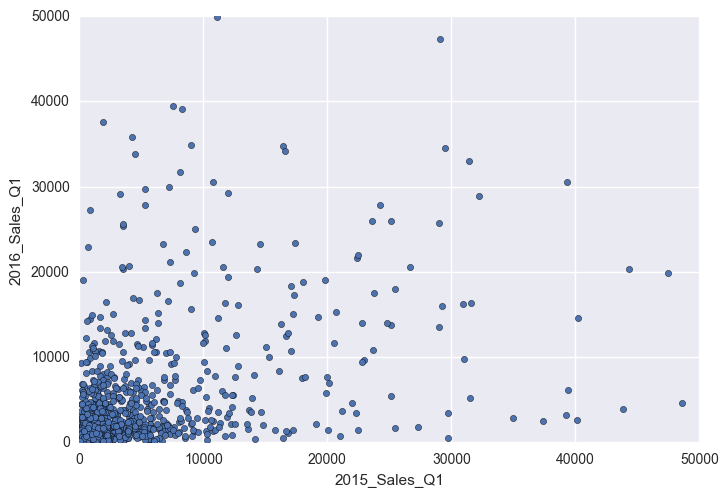

In [19]:
# Quick plot to check the computations
sales.plot(kind='scatter', x="2015_Sales_Q1", y="2016_Sales_Q1");
plt.xlim(0, 50000)
plt.ylim(0, 50000)

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

## Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

## Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

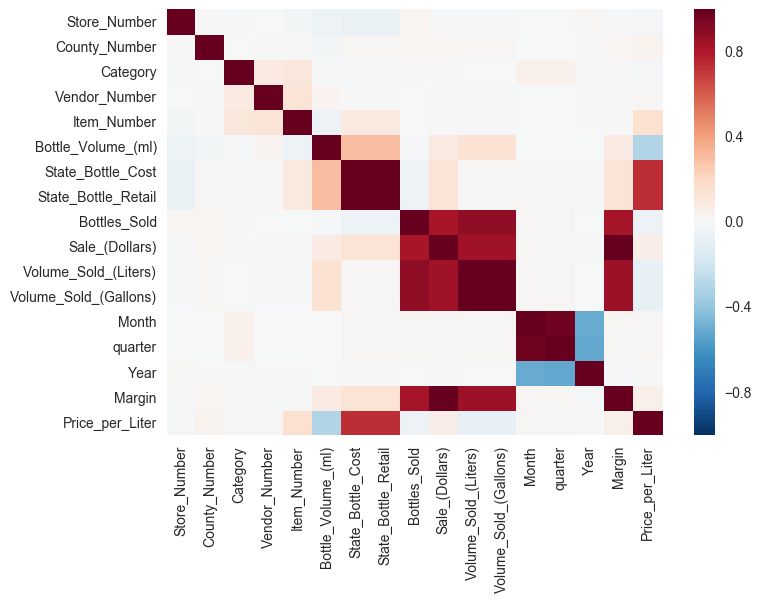

In [20]:
sns.heatmap(df.corr())

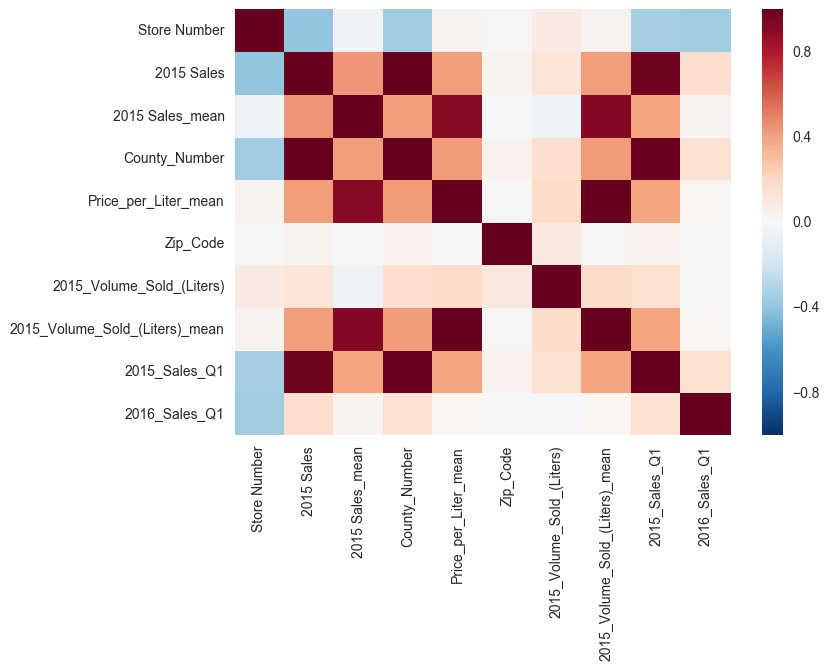

In [21]:
sns.heatmap(sales.corr())

## Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [22]:
from sklearn import linear_model


In [23]:
df_2 = df.copy()


In [24]:
del df_2['Date']
del df_2['City']


In [25]:
df_2.head()

,Store_Number,Zip_Code,County_Number,Category,Vendor_Number,Item_Number,Bottle_Volume_(ml),State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_(Dollars),Volume_Sold_(Liters),Volume_Sold_(Gallons),Month,quarter,Year,Margin,Price_per_Liter
22111,2106,50613,7,1062200,35,43127,1000,9.50,14.25,36,513.00,36.0,9.51,1,1,2015,171.00,14.25
47659,2106,50613,7,1022100,410,88296,750,27.00,40.50,12,486.00,9.0,2.38,1,1,2015,162.00,54.00
65214,2106,50613,7,1062310,259,43026,750,5.78,8.67,12,104.04,9.0,2.38,1,1,2015,34.68,11.56
66346,2106,50613,7,1081200,305,73055,750,12.50,18.75,12,225.00,9.0,2.38,1,1,2015,75.00,25.00
80570,2106,50613,7,1062200,434,46351,1000,4.34,6.51,12,78.12,12.0,3.17,1,1,2015,26.04,6.51


In [26]:
del df_2['Zip_Code']

In [27]:
X = df_2[(df_2['quarter'] == 1) & (df_2['Year'] == 2015)]
y = df_2['Sale_(Dollars)'][(df_2['quarter'] == 1) & (df_2['Year'] == 2015)]

In [28]:
X.dtypes

Store_Number               int64
County_Number              int64
Category                   int64
Vendor_Number              int64
Item_Number                int64
Bottle_Volume_(ml)         int64
State_Bottle_Cost        float64
State_Bottle_Retail      float64
Bottles_Sold               int64
Sale_(Dollars)           float64
Volume_Sold_(Liters)     float64
Volume_Sold_(Gallons)    float64
Month                      int64
quarter                    int64
Year                       int64
Margin                   float64
Price_per_Liter          float64
dtype: object

In [29]:
y.shape

(47791,)

In [30]:
X_2 = df_2[(df_2['quarter'] == 1) & (df_2['Year'] == 2016)]

In [31]:
y_2 = df_2['Sale_(Dollars)'][(df_2['quarter'] == 1) & (df_2['Year'] == 2016)]

In [32]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
predictions = model.predict(X_2)
predictions2 = model.predict(X)
print predictions
print predictions.sum()
print y.sum()
print predictions2.sum()

[ 188.88  226.68   19.98 ...,  163.68  163.68  177.48]
5976046.47
5966406.92
5966406.92


In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_2 , predictions ))
rms

4.433324930875835e-12

In [34]:
rms = sqrt(mean_squared_error(y , predictions2 ))
rms

4.43239767525382e-12

In [35]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.4)

In [36]:
print X_train.shape
print X_test.shape

(28674, 17)
(19117, 17)


In [37]:
print y_train.shape
print y_test.shape

(28674,)
(19117,)


In [38]:
lm_2 = linear_model.LinearRegression()
linear_tts = lm_2.fit(X_train, y_train)

In [39]:
y_pred = linear_tts.predict(X_test)
rmse_2 = sqrt(mean_squared_error(y_test , y_pred ))
print rmse_2

4.82276546029e-12


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

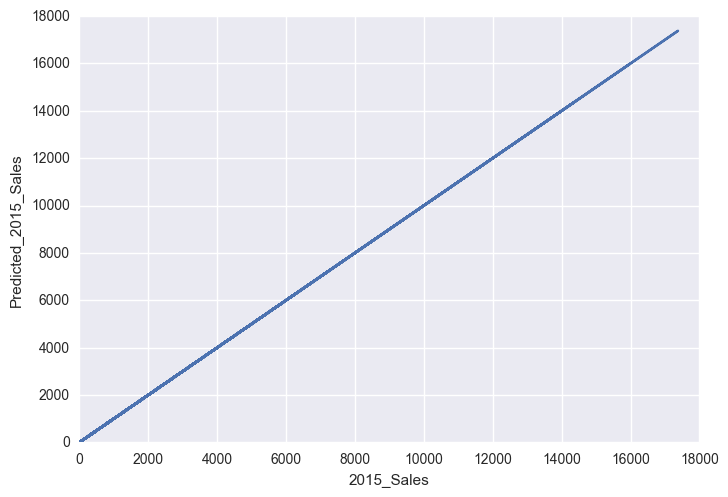

In [40]:
plt.plot(y, predictions2)
plt.xlabel('2015_Sales')
plt.ylabel('Predicted_2015_Sales')


- The above graph shows a perfect linear relationship between the original data and the predicted sales data. Which, 
reinforces the RMSE scores. This adds some validity to the predicted sales data for 2016, and gives us some confidence in our model.  

## Present the Results

Present your conclusions and results, including a Tableau Storyboard. If you have more than one interesting model feel free to include.

In [41]:
df.to_csv("DF_clean.csv")


In [42]:
sales.to_csv("Sales.csv")

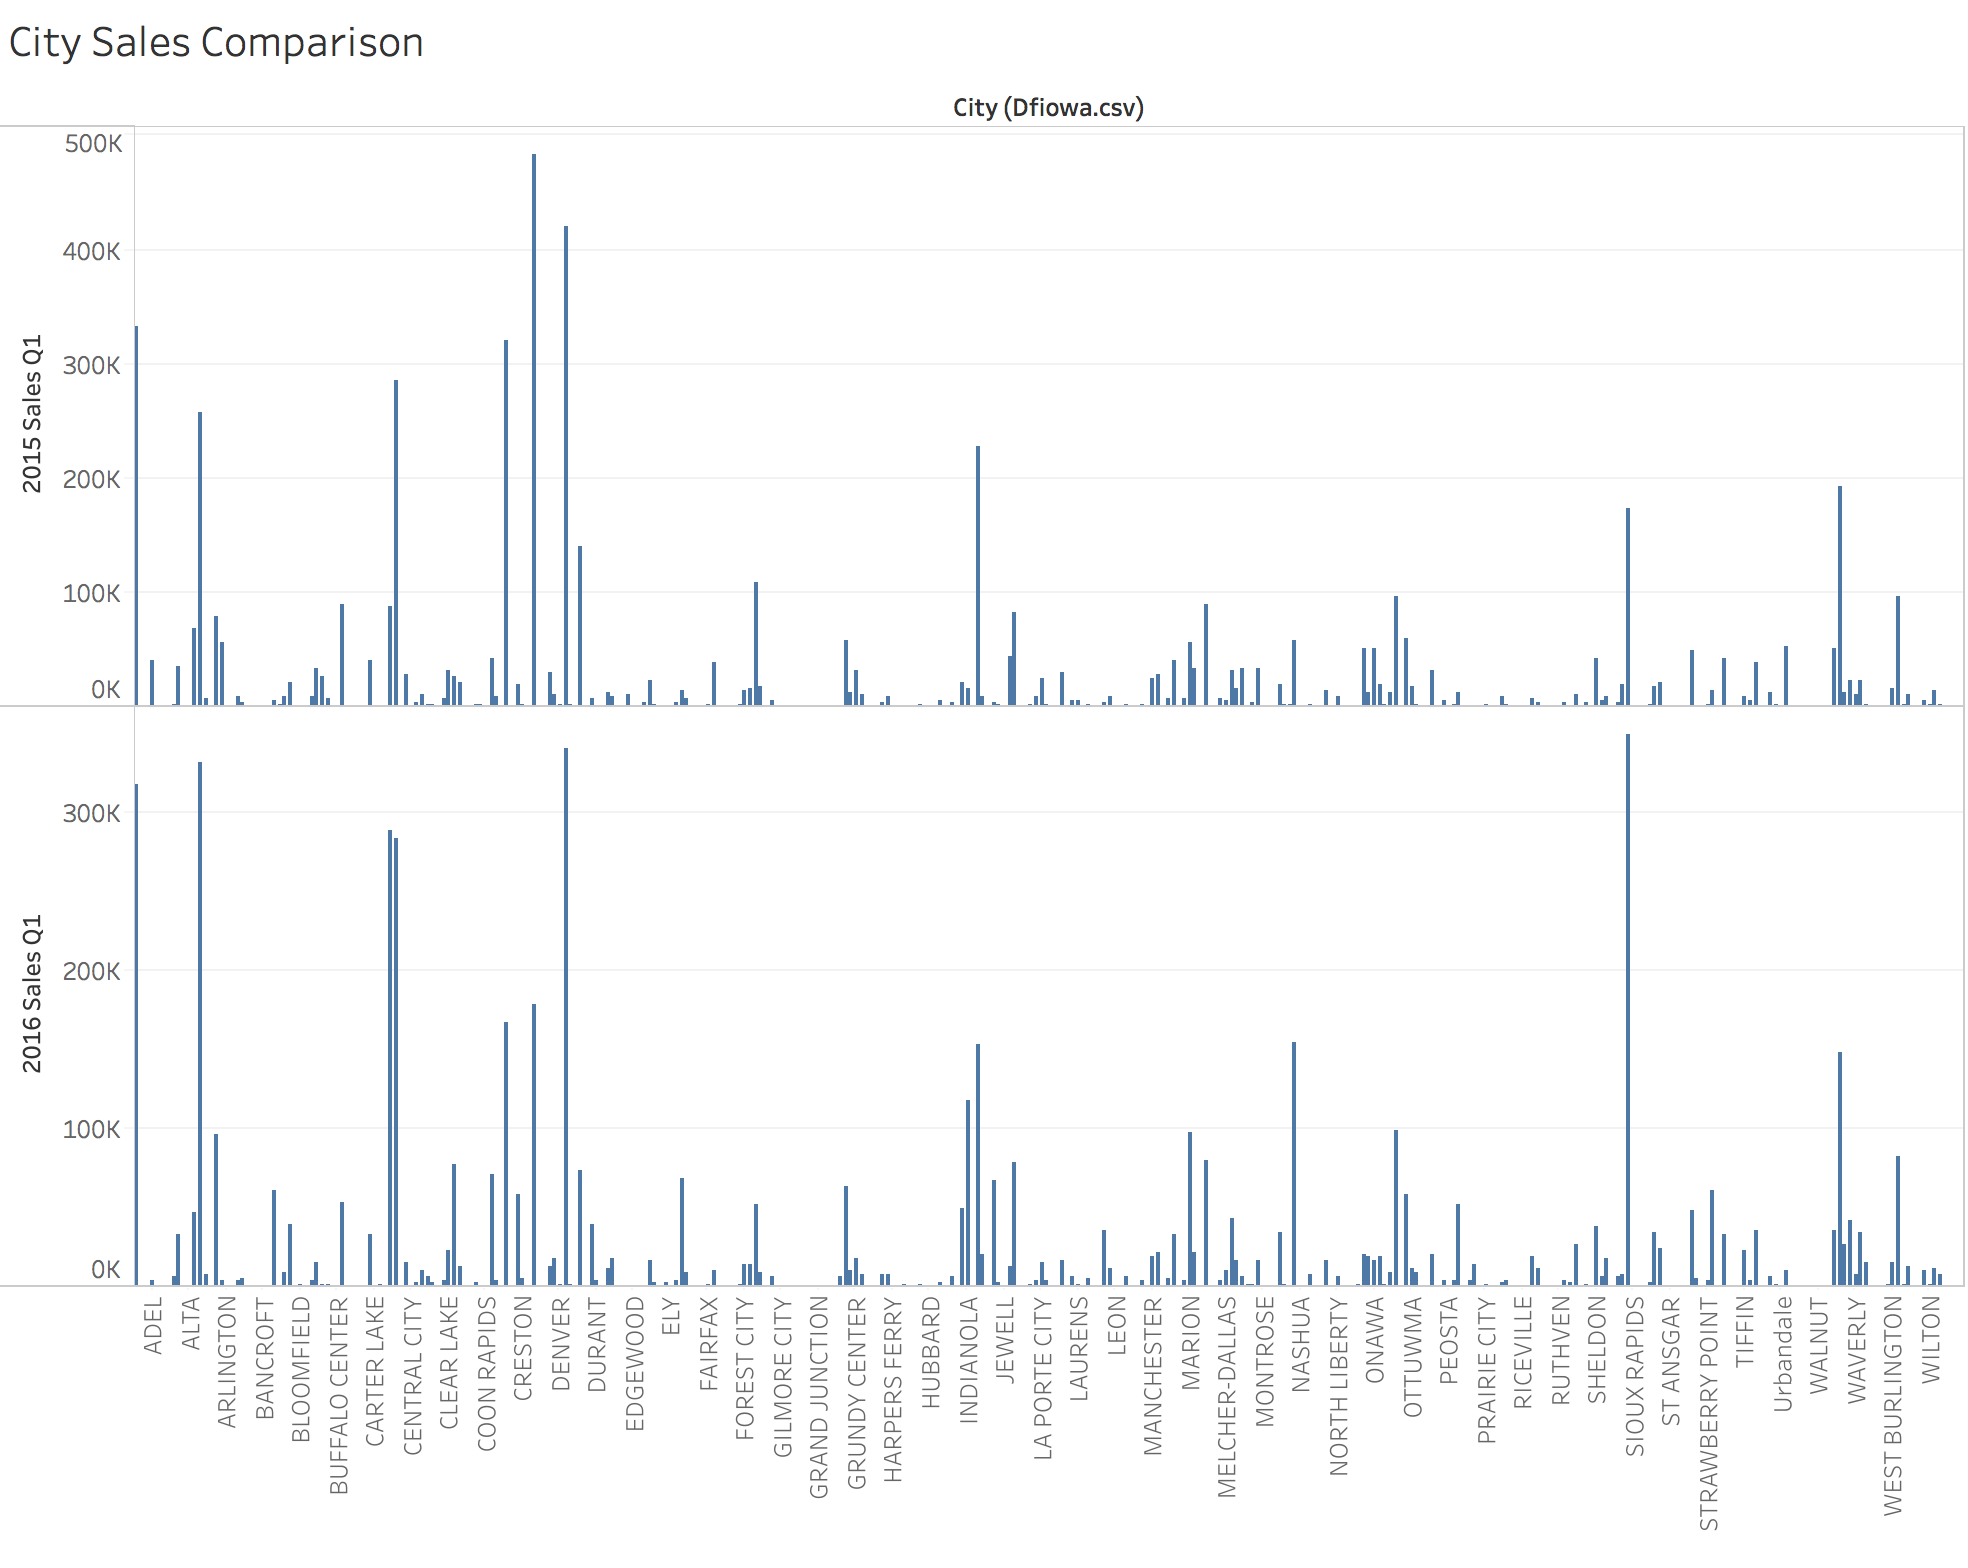

In [43]:
from IPython.display import Image
Image(filename = 'CitySalesComparison.png')

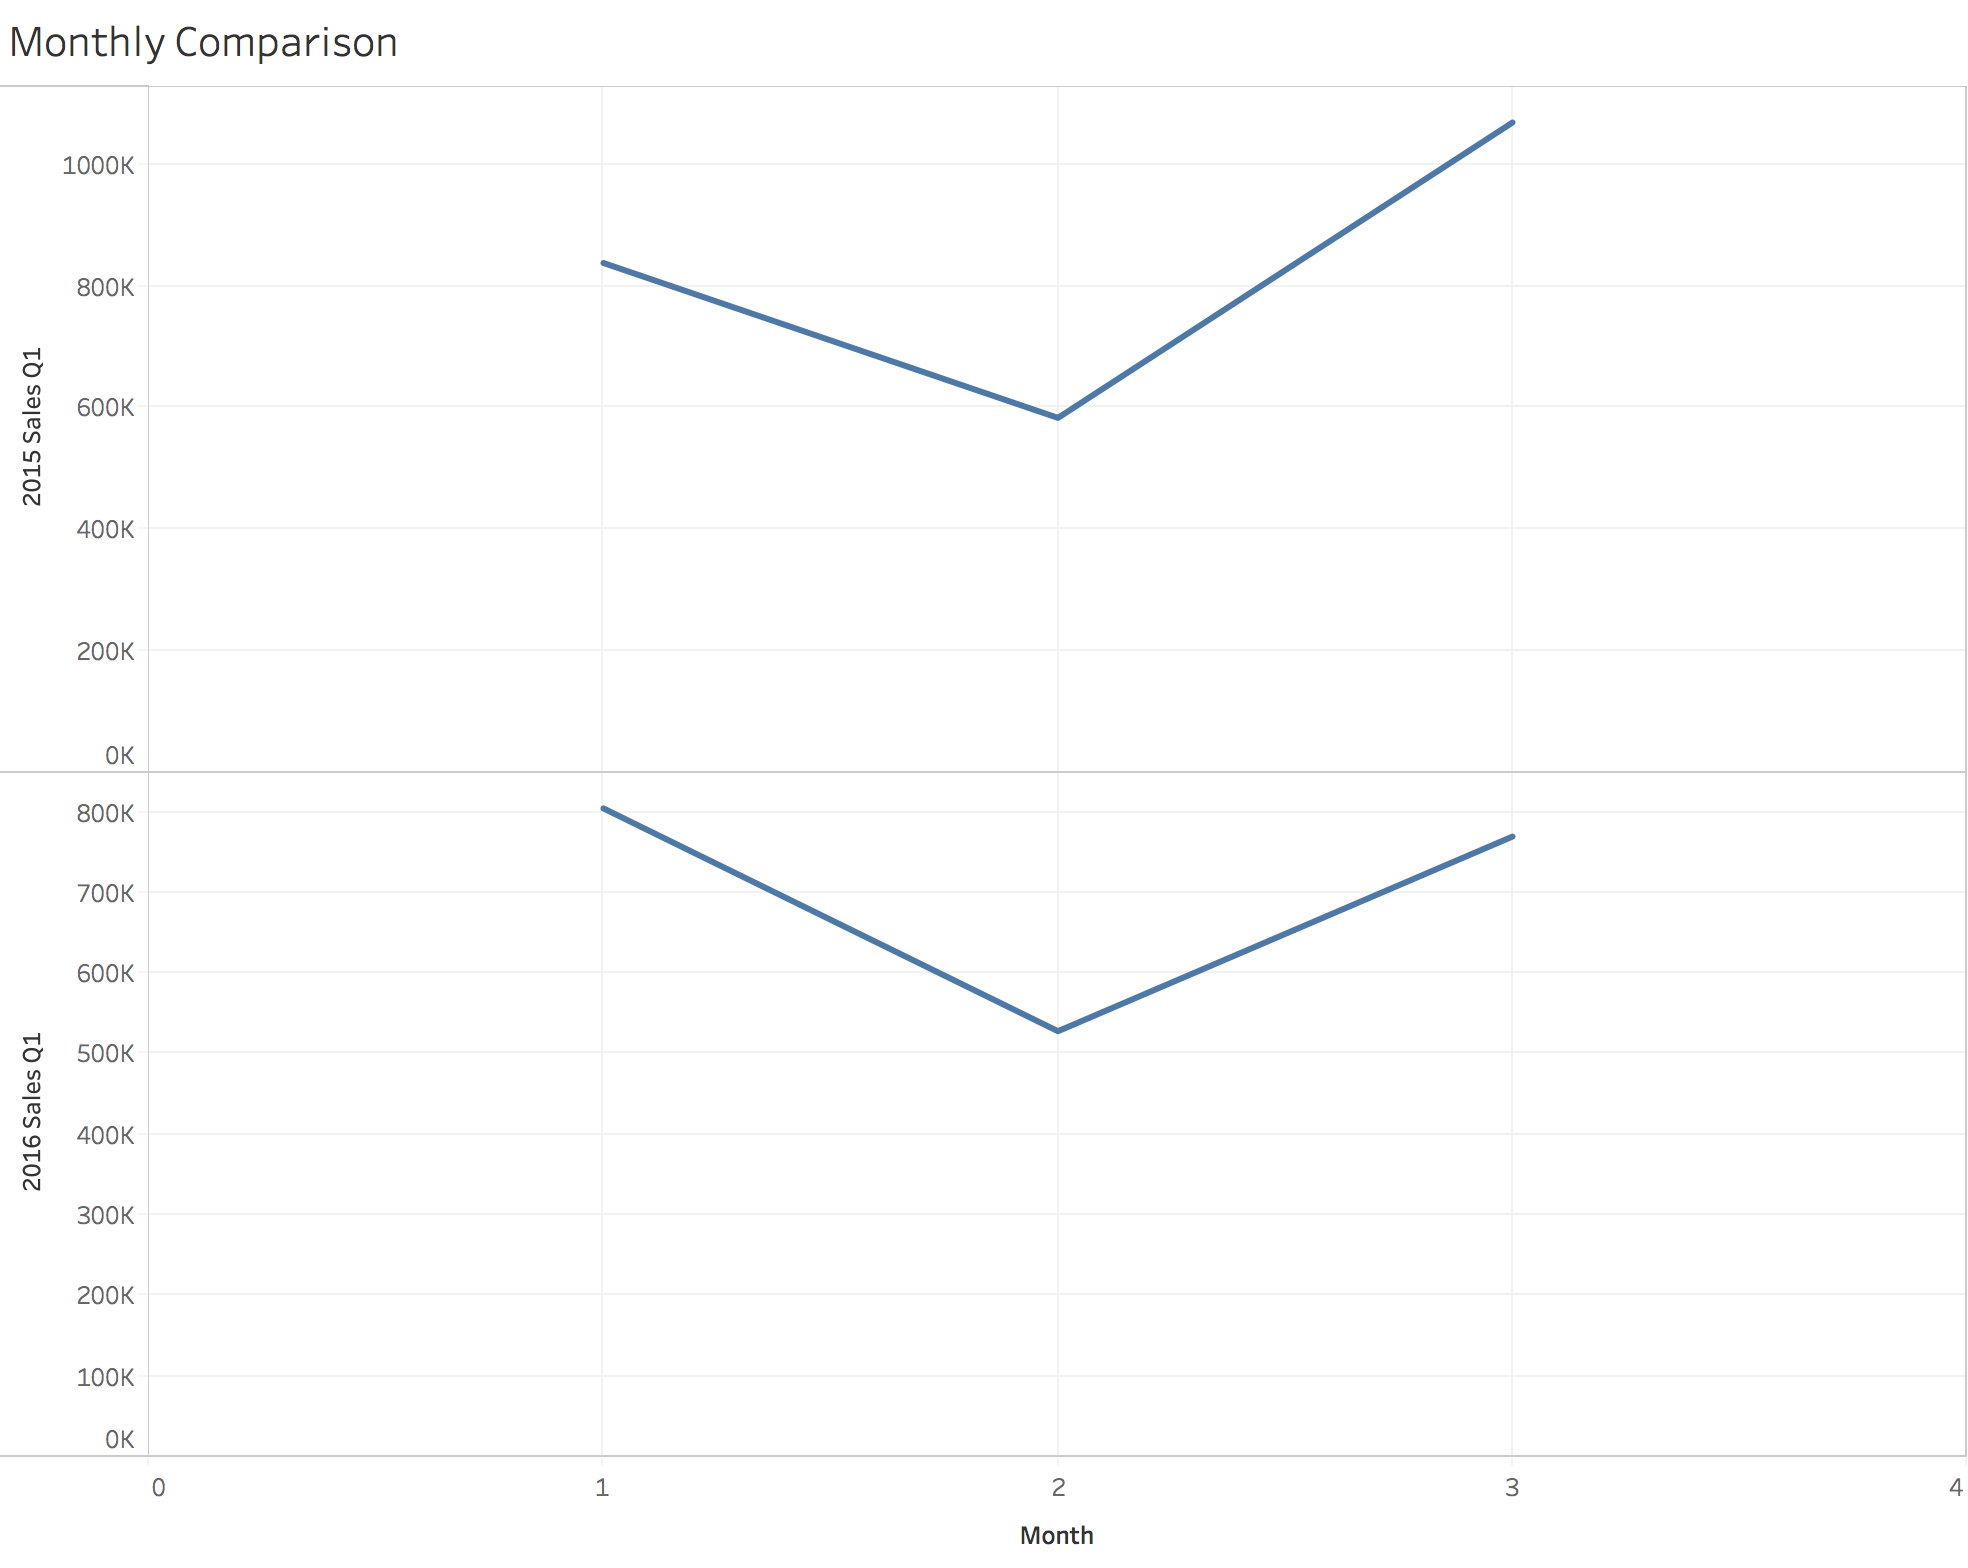

In [44]:
Image(filename = 'MonthlyComparison.png')

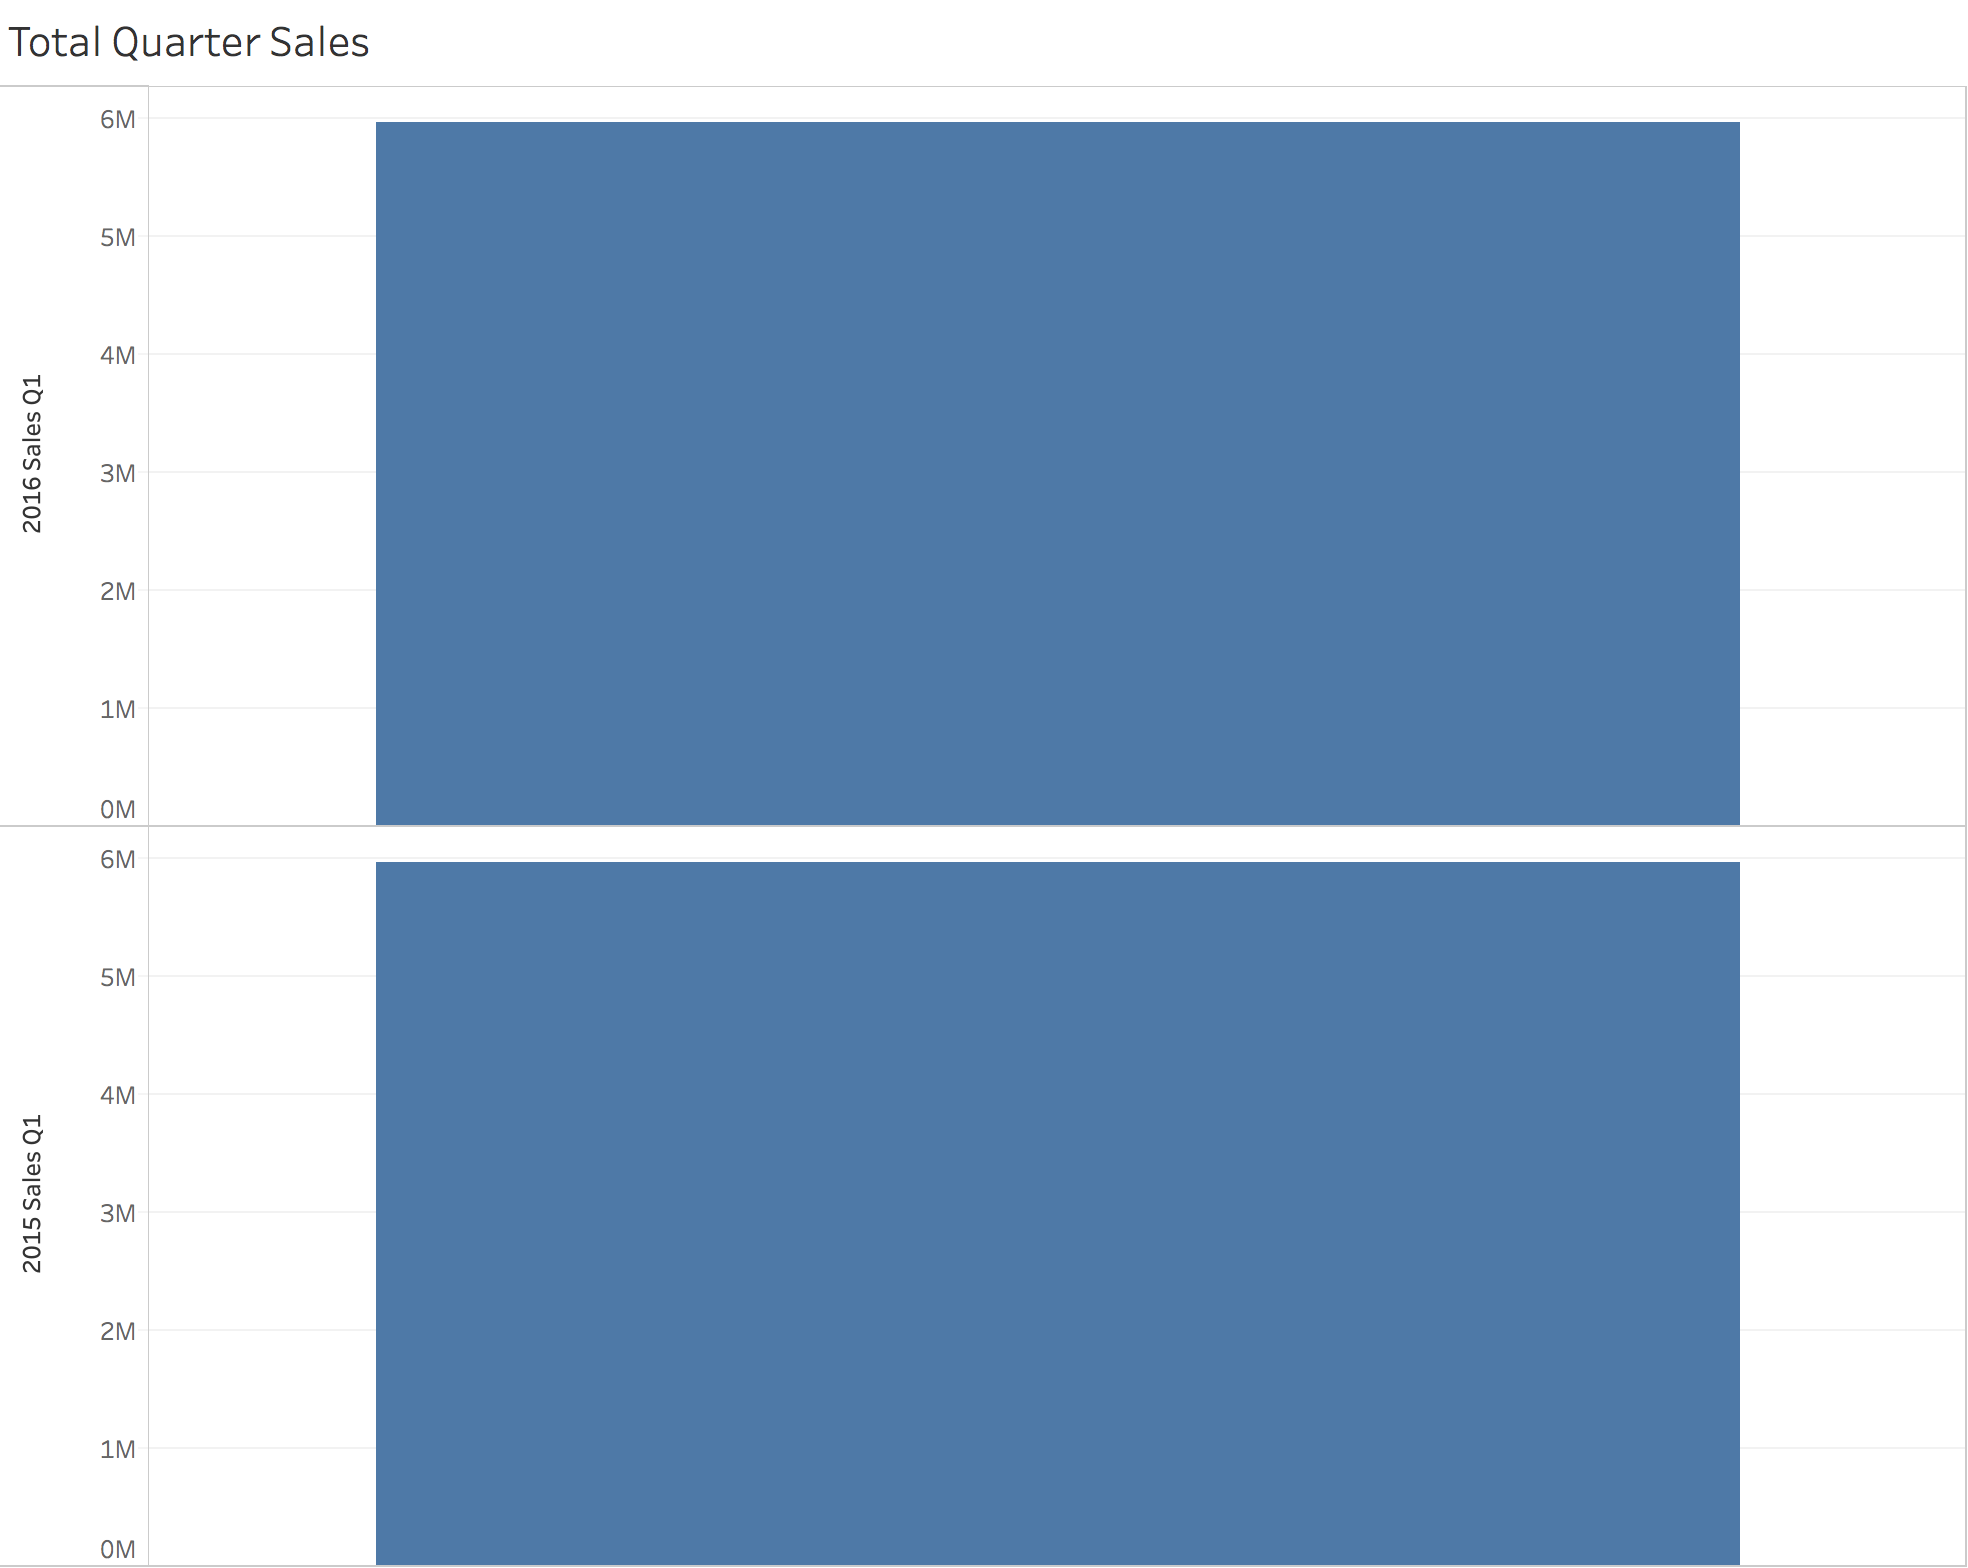

In [45]:
Image(filename = 'TotalQuarterSales.png')

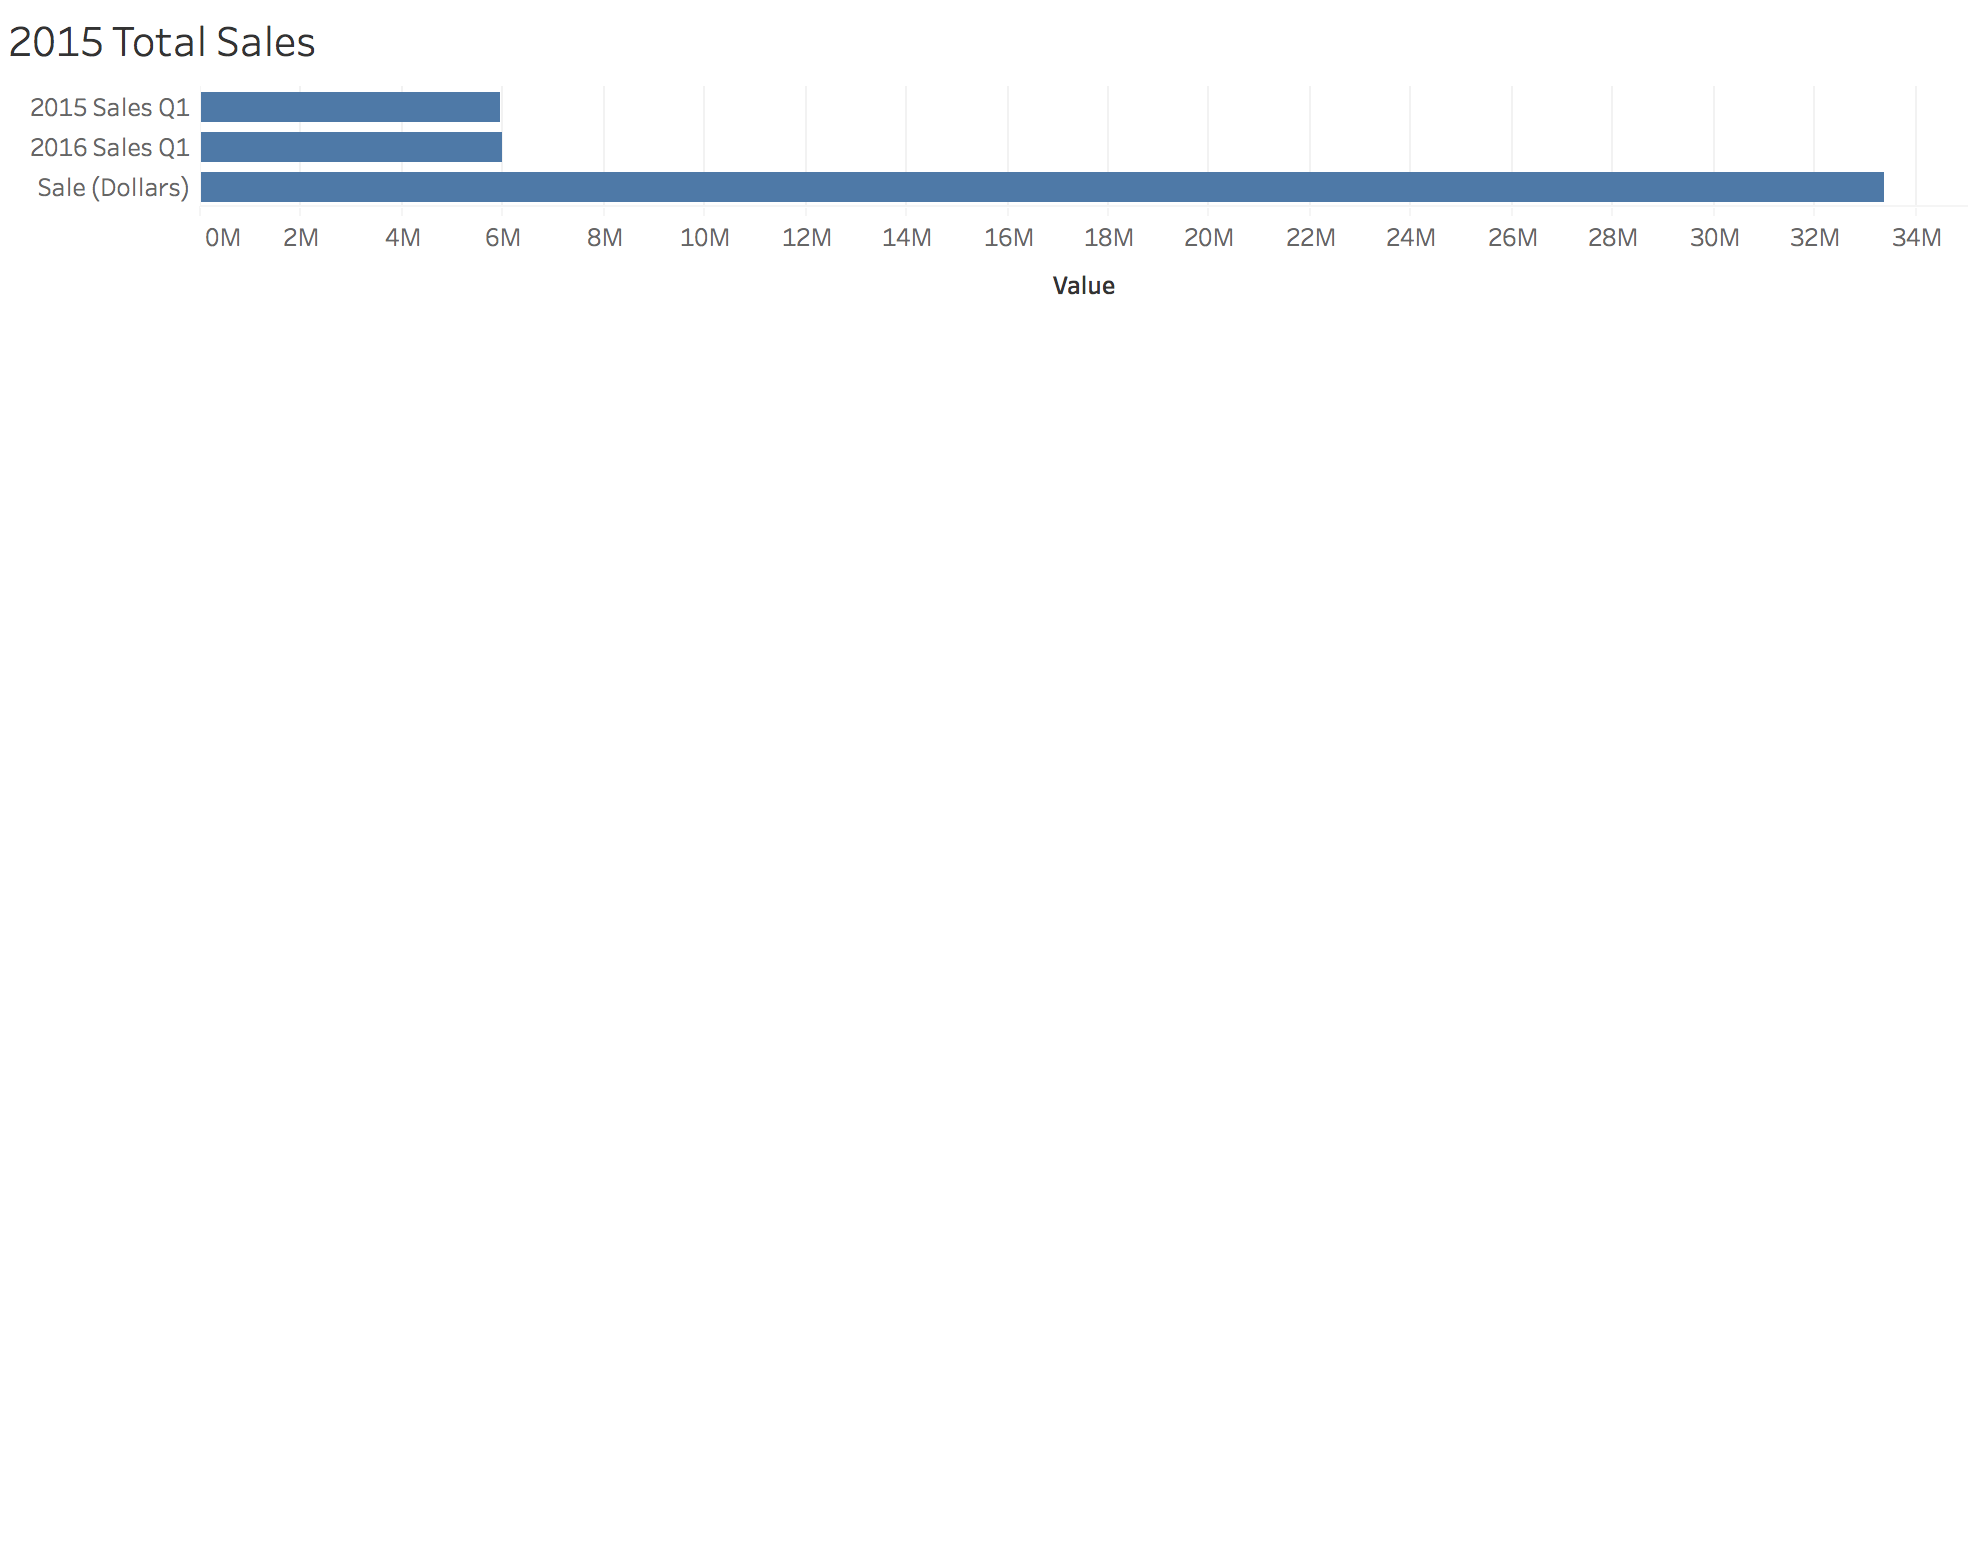

In [46]:
Image(filename = '2015TotalSales.png')

#blog link: https://mushgrant.github.io/

Score | /24
----|----
Identify: Problem Statement and Risks | 
Acquire: Import with Pandas| 
Parse: EDA | 
Mine: Create columns/clean/format/process data| 
Refine: Determine outliers and distribution, correlation, & statistical analysis| 
Model: Create linear models; calculate probabilities, evaluate model, perform CV| 
Present: Create executive summary, present findings, summarize, tailored for your audience|
Present: Blog |
Bonus: perform Ridge and Lasso regularization and explain what they do | 